<a href="https://colab.research.google.com/github/SAMashiyane/ANN_Salary/blob/main/Body_packer_detection_RetinanNET_final_100epoch_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Aug 21 08:28:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18, resnet34
import os

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##Mount google drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##custom dataset

In [5]:
from PIL import Image
import os
import os.path
from typing import Any, Callable, Optional, Tuple, List
import torchvision.transforms.functional as F

class bodyDetection(torch.utils.data.Dataset):

    def __init__(
        self,
        root: str,
        annFile: str,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
    ):
        # super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO

        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms
        self.transform = transform

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        # print(target)
        targets = {}
        targets['boxes'] = torch.tensor([item['bbox'] for item in target])#.view(-1, 4)
        targets['labels'] = torch.tensor([item['category_id'] for item in target])#.view(-1)

        if self.transforms is not None:
          image = F.to_tensor(image).permute(1, 2, 0).numpy()
          transformed = transform(image=image, bboxes=targets['boxes'], category_ids=targets['labels'])

        image = torch.tensor(transformed['image']).permute(2, 0, 1)
        targets['boxes'] = torch.tensor(transformed['bboxes'])
        if targets['boxes'].numel() > 0:
            targets['area'] = targets['boxes'][:, 2] * targets['boxes'][:, 3]
            # print(targets['boxes'].shape)
            targets['boxes'][:, 2] += targets['boxes'][:, 0]
            targets['boxes'][:, 3] += targets['boxes'][:, 1]
            targets['labels'] = torch.tensor(transformed['category_ids'])
            targets['image_id'] = torch.tensor(target[0]['image_id'])
            targets['iscrowd'] = torch.tensor([item['iscrowd'] for item in target])
        else:
            targets = {}

        return image, targets

    def __len__(self) -> int:
        return len(self.ids)

In [6]:
import albumentations as A

In [7]:
transform = A.Compose([  A.HorizontalFlip(p=0),
                        # A.ShiftScaleRotate(p=0.9),
                       A.RandomBrightness(p=0.3)],
                      bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [8]:
transform_train = A.Compose([A.HorizontalFlip(p=0),
                            #  [A.Resize(416, 416)],
                      #  A.ShiftScaleRotate(p=0.9),
                          A.RandomBrightness(p=0.3)],
                      bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

transform_test = A.Compose([A.HorizontalFlip(p=0),
                            #  [A.Resize(416, 416)],
                      #  A.ShiftScaleRotate(p=0.9),
                          A.RandomBrightness(p=0.3)],
                      bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

In [9]:
def new_concat(batch):
  return tuple(zip(*batch))

In [10]:
def get_loader(root, json, transform=None, batch_size=1, shuffle=False, num_workers=4):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    dataset = bodyDetection(root=root,
                       annFile=json,
                       transforms=transform)

    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=new_concat)
    return data_loader, dataset

In [11]:
trainloader, trainset = get_loader('/content/drive/MyDrive/train_bodypacker333', '/content/drive/MyDrive/train_bodypacker333/result.json', shuffle=True, transform=transform_train)

testloader, testset = get_loader('/content/drive/MyDrive/test_bodypacker111', '/content/drive/MyDrive/test_bodypacker111/result.json', shuffle=True, transform=transform_test)

loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


## Check and visualize dataset

## Model

In [12]:
net = torchvision.models.detection.retinanet_resnet50_fpn(True)
net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:08<00:00, 17.0MB/s]


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


## Config

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
import sys
import logging
from torch.utils.tensorboard import SummaryWriter
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('FineTune')
# logger.setLevel(logging.INFO)
writer = SummaryWriter()

In [15]:
logging.info('test')

INFO:root:test


In [16]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20000)

## Train & Test

In [ ]:
# %%shell

# # Download TorchVision repo to use some files from
# # references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.0

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084d8 version check against PyTorch's CUDA version


In [17]:
%%shell

Download TorchVision repo to use some files from
references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

/bin/bash: line 2: Download: command not found
/bin/bash: line 3: references/detection: No such file or directory
Cloning into 'vision'...
remote: Enumerating objects: 360389, done.
remote: Counting objects: 100% (10629/10629), done.
remote: Compressing objects: 100% (946/946), done.
remote: Total 360389 (delta 9839), reused 10333 (delta 9620), pack-reused 349760
Receiving objects: 100% (360389/360389), 719.55 MiB | 22.59 MiB/s, done.
Resolving deltas: 100% (332387/332387), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable

In [18]:
from engine import train_one_epoch, evaluate
import utils

In [19]:
# Training
def train(epoch):
    net.train()
    loss_total = AverageMeter()
    # accuracy = torchmetrics.Accuracy().cuda()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # inputs, targets = inputs.to(device), targets.to(device)
        inputs = [image.to(device) for image in inputs]

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = net(inputs, targets)
        loss = sum(loss for loss in loss_dict.values())
        # loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_total.update(loss)
        # accuracy(outputs.softmax(dim=-1), targets)
        # print(targets[:10])
        # if batch_idx == 20:
        #     break
        scheduler.step()
    # acc = accuracy.compute()
    writer.add_scalar('Loss/train', loss_total.avg.item(), epoch)
    # writer.add_scalar('Acc/train', acc.item(), epoch)
    logger.info(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4}')
    # logger.info(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4} Accuracy:{acc:.4}')


def test(epoch, checkpoint):
    net.eval()
    loss_total = AverageMeter()
    # accuracy = torchmetrics.Accuracy().cuda()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # inputs, targets = inputs.to(device), targets.to(device)
            inputs = [image.to(device) for image in inputs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = net(inputs)
            # loss = criterion(outputs, targets)
            # loss_total.update(loss)
            # accuracy(outputs.softmax(dim=-1), targets)
        # acc = accuracy.compute()
        # writer.add_scalar('Loss/test', loss_total.avg.item(), epoch)
        # writer.add_scalar('Acc/test', acc.item(), epoch)
        # logger.info(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4}')
        # logger.info(f'Test:  Epoch:{epoch} Loss:{loss_total.avg:.4} Accuracy:{acc:.4}')
        # print()
    # Save checkpoint
    # checkpoint.save(accuracy.compute(), epoch=epoch)


class Checkpoint(object):
    def __init__(self, model_name):
        self.best_acc = 0.
        self.folder = 'checkpoint'
        self.model_name = model_name
        os.makedirs(self.folder, exist_ok=True)
    def save(self, acc, epoch=-1):
        if acc > self.best_acc:
            logger.info('Saving checkpoint...')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            path = os.path.join(os.path.abspath(self.folder), self.model_name + '.pth')
            torch.save(state, path)
            self.best_acc = acc
    def load(self, net):
        pass

In [ ]:
# pip install --upgrade torch torchvision

In [20]:
# writer = SummaryWriter()
checkpoint = Checkpoint('ckpt-retina-dar-detection')
start, end = 0, 100
for epoch in range(start, end):
    train(epoch)
    # train_one_epoch(net,optimizer,trainloader,device=device,3,)
    # test(epoch, checkpoint)
    evaluate(net, testloader, device=device)

writer.close()

INFO:FineTune:Train: Epoch:0 Loss:1.487


creating index...
index created!
Test:  [  0/111]  eta: 0:00:44  model_time: 0.1754 (0.1754)  evaluator_time: 0.0190 (0.0190)  time: 0.3980  data: 0.2023  max mem: 2002
Test:  [100/111]  eta: 0:00:01  model_time: 0.0970 (0.1005)  evaluator_time: 0.0066 (0.0124)  time: 0.1162  data: 0.0033  max mem: 2002
Test:  [110/111]  eta: 0:00:00  model_time: 0.0932 (0.1005)  evaluator_time: 0.0066 (0.0120)  time: 0.1128  data: 0.0032  max mem: 2002
Test: Total time: 0:00:13 (0.1189 s / it)
Averaged stats: model_time: 0.0932 (0.1005)  evaluator_time: 0.0066 (0.0120)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:1 Loss:0.7585


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0961 (0.0961)  evaluator_time: 0.0114 (0.0114)  time: 0.3109  data: 0.2021  max mem: 2002
Test:  [100/111]  eta: 0:00:01  model_time: 0.1018 (0.1041)  evaluator_time: 0.0108 (0.0112)  time: 0.1228  data: 0.0033  max mem: 2002
Test:  [110/111]  eta: 0:00:00  model_time: 0.1018 (0.1044)  evaluator_time: 0.0099 (0.0114)  time: 0.1221  data: 0.0033  max mem: 2002
Test: Total time: 0:00:13 (0.1224 s / it)
Averaged stats: model_time: 0.1018 (0.1044)  evaluator_time: 0.0099 (0.0114)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.699
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:2 Loss:1.101


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1046 (0.1046)  evaluator_time: 0.0132 (0.0132)  time: 0.3178  data: 0.1989  max mem: 2003
Test:  [100/111]  eta: 0:00:01  model_time: 0.1026 (0.1064)  evaluator_time: 0.0092 (0.0123)  time: 0.1263  data: 0.0033  max mem: 2003
Test:  [110/111]  eta: 0:00:00  model_time: 0.1015 (0.1068)  evaluator_time: 0.0146 (0.0129)  time: 0.1338  data: 0.0034  max mem: 2003
Test: Total time: 0:00:14 (0.1262 s / it)
Averaged stats: model_time: 0.1015 (0.1068)  evaluator_time: 0.0146 (0.0129)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:3 Loss:0.6474


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1029 (0.1029)  evaluator_time: 0.0116 (0.0116)  time: 0.3211  data: 0.2053  max mem: 2003
Test:  [100/111]  eta: 0:00:01  model_time: 0.1047 (0.1071)  evaluator_time: 0.0087 (0.0119)  time: 0.1251  data: 0.0034  max mem: 2003
Test:  [110/111]  eta: 0:00:00  model_time: 0.1042 (0.1068)  evaluator_time: 0.0082 (0.0118)  time: 0.1252  data: 0.0033  max mem: 2003
Test: Total time: 0:00:13 (0.1253 s / it)
Averaged stats: model_time: 0.1042 (0.1068)  evaluator_time: 0.0082 (0.0118)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.742
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:4 Loss:0.4943


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0978 (0.0978)  evaluator_time: 0.0065 (0.0065)  time: 0.3148  data: 0.2093  max mem: 2003
Test:  [100/111]  eta: 0:00:01  model_time: 0.1035 (0.1073)  evaluator_time: 0.0081 (0.0111)  time: 0.1263  data: 0.0035  max mem: 2003
Test:  [110/111]  eta: 0:00:00  model_time: 0.1014 (0.1074)  evaluator_time: 0.0076 (0.0108)  time: 0.1178  data: 0.0034  max mem: 2003
Test: Total time: 0:00:13 (0.1249 s / it)
Averaged stats: model_time: 0.1014 (0.1074)  evaluator_time: 0.0076 (0.0108)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.759
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:5 Loss:0.4108


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1025 (0.1025)  evaluator_time: 0.0079 (0.0079)  time: 0.3280  data: 0.2164  max mem: 2003
Test:  [100/111]  eta: 0:00:01  model_time: 0.1042 (0.1080)  evaluator_time: 0.0029 (0.0067)  time: 0.1178  data: 0.0033  max mem: 2003
Test:  [110/111]  eta: 0:00:00  model_time: 0.0980 (0.1077)  evaluator_time: 0.0025 (0.0071)  time: 0.1155  data: 0.0033  max mem: 2003
Test: Total time: 0:00:13 (0.1215 s / it)
Averaged stats: model_time: 0.0980 (0.1077)  evaluator_time: 0.0025 (0.0071)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:6 Loss:0.3607


creating index...
index created!
Test:  [  0/111]  eta: 0:00:38  model_time: 0.0976 (0.0976)  evaluator_time: 0.0256 (0.0256)  time: 0.3472  data: 0.2228  max mem: 2003
Test:  [100/111]  eta: 0:00:01  model_time: 0.1050 (0.1082)  evaluator_time: 0.0067 (0.0100)  time: 0.1213  data: 0.0031  max mem: 2003
Test:  [110/111]  eta: 0:00:00  model_time: 0.1044 (0.1077)  evaluator_time: 0.0049 (0.0102)  time: 0.1202  data: 0.0031  max mem: 2003
Test: Total time: 0:00:13 (0.1243 s / it)
Averaged stats: model_time: 0.1044 (0.1077)  evaluator_time: 0.0049 (0.0102)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:7 Loss:0.3144


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1073 (0.1073)  evaluator_time: 0.0036 (0.0036)  time: 0.3163  data: 0.2042  max mem: 2003
Test:  [100/111]  eta: 0:00:01  model_time: 0.1032 (0.1079)  evaluator_time: 0.0024 (0.0058)  time: 0.1158  data: 0.0032  max mem: 2003
Test:  [110/111]  eta: 0:00:00  model_time: 0.1048 (0.1081)  evaluator_time: 0.0041 (0.0062)  time: 0.1187  data: 0.0033  max mem: 2003
Test: Total time: 0:00:13 (0.1209 s / it)
Averaged stats: model_time: 0.1048 (0.1081)  evaluator_time: 0.0041 (0.0062)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:8 Loss:0.3416


creating index...
index created!
Test:  [  0/111]  eta: 0:00:40  model_time: 0.1442 (0.1442)  evaluator_time: 0.0117 (0.0117)  time: 0.3673  data: 0.2101  max mem: 2003
Test:  [100/111]  eta: 0:00:01  model_time: 0.0996 (0.1083)  evaluator_time: 0.0073 (0.0111)  time: 0.1173  data: 0.0034  max mem: 2003
Test:  [110/111]  eta: 0:00:00  model_time: 0.0994 (0.1085)  evaluator_time: 0.0059 (0.0107)  time: 0.1186  data: 0.0032  max mem: 2003
Test: Total time: 0:00:13 (0.1260 s / it)
Averaged stats: model_time: 0.0994 (0.1085)  evaluator_time: 0.0059 (0.0107)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:9 Loss:0.2887


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1043 (0.1043)  evaluator_time: 0.0039 (0.0039)  time: 0.3314  data: 0.2221  max mem: 2003
Test:  [100/111]  eta: 0:00:01  model_time: 0.1033 (0.1086)  evaluator_time: 0.0024 (0.0056)  time: 0.1168  data: 0.0034  max mem: 2003
Test:  [110/111]  eta: 0:00:00  model_time: 0.1038 (0.1088)  evaluator_time: 0.0034 (0.0061)  time: 0.1215  data: 0.0034  max mem: 2003
Test: Total time: 0:00:13 (0.1216 s / it)
Averaged stats: model_time: 0.1038 (0.1088)  evaluator_time: 0.0034 (0.0061)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:10 Loss:0.2689


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.0984 (0.0984)  evaluator_time: 0.0058 (0.0058)  time: 0.3213  data: 0.2159  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1043 (0.1084)  evaluator_time: 0.0029 (0.0069)  time: 0.1214  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1032 (0.1083)  evaluator_time: 0.0020 (0.0066)  time: 0.1182  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1215 s / it)
Averaged stats: model_time: 0.1032 (0.1083)  evaluator_time: 0.0020 (0.0066)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:11 Loss:0.236


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1021 (0.1021)  evaluator_time: 0.0068 (0.0068)  time: 0.3184  data: 0.2082  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.0993 (0.1077)  evaluator_time: 0.0021 (0.0065)  time: 0.1140  data: 0.0037  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1027 (0.1078)  evaluator_time: 0.0033 (0.0067)  time: 0.1182  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1213 s / it)
Averaged stats: model_time: 0.1027 (0.1078)  evaluator_time: 0.0033 (0.0067)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.827
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:12 Loss:0.2181


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0947 (0.0947)  evaluator_time: 0.0028 (0.0028)  time: 0.3092  data: 0.2103  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1075 (0.1079)  evaluator_time: 0.0022 (0.0064)  time: 0.1225  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1043 (0.1081)  evaluator_time: 0.0023 (0.0062)  time: 0.1219  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1211 s / it)
Averaged stats: model_time: 0.1043 (0.1081)  evaluator_time: 0.0023 (0.0062)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.826
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:13 Loss:0.1979


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1059 (0.1059)  evaluator_time: 0.0033 (0.0033)  time: 0.3097  data: 0.1994  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1043 (0.1084)  evaluator_time: 0.0023 (0.0058)  time: 0.1152  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.0998 (0.1083)  evaluator_time: 0.0027 (0.0061)  time: 0.1184  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1211 s / it)
Averaged stats: model_time: 0.0998 (0.1083)  evaluator_time: 0.0027 (0.0061)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.829
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:14 Loss:0.1856


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0950 (0.0950)  evaluator_time: 0.0035 (0.0035)  time: 0.3081  data: 0.2084  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1057 (0.1078)  evaluator_time: 0.0027 (0.0058)  time: 0.1232  data: 0.0036  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1038 (0.1080)  evaluator_time: 0.0021 (0.0059)  time: 0.1238  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1206 s / it)
Averaged stats: model_time: 0.1038 (0.1080)  evaluator_time: 0.0021 (0.0059)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.839
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:15 Loss:0.1713


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0988 (0.0988)  evaluator_time: 0.0024 (0.0024)  time: 0.3110  data: 0.2085  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1040 (0.1085)  evaluator_time: 0.0028 (0.0056)  time: 0.1189  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1035 (0.1081)  evaluator_time: 0.0018 (0.0058)  time: 0.1191  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1206 s / it)
Averaged stats: model_time: 0.1035 (0.1081)  evaluator_time: 0.0018 (0.0058)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.833
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:16 Loss:0.1676


creating index...
index created!
Test:  [  0/111]  eta: 0:00:38  model_time: 0.1283 (0.1283)  evaluator_time: 0.0029 (0.0029)  time: 0.3457  data: 0.2136  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1036 (0.1083)  evaluator_time: 0.0029 (0.0060)  time: 0.1211  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1030 (0.1083)  evaluator_time: 0.0034 (0.0058)  time: 0.1192  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1209 s / it)
Averaged stats: model_time: 0.1030 (0.1083)  evaluator_time: 0.0034 (0.0058)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:17 Loss:0.1611


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1024 (0.1024)  evaluator_time: 0.0037 (0.0037)  time: 0.3262  data: 0.2188  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1033 (0.1083)  evaluator_time: 0.0022 (0.0055)  time: 0.1192  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1031 (0.1083)  evaluator_time: 0.0022 (0.0056)  time: 0.1172  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1208 s / it)
Averaged stats: model_time: 0.1031 (0.1083)  evaluator_time: 0.0022 (0.0056)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.828
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:18 Loss:0.1481


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1082 (0.1082)  evaluator_time: 0.0025 (0.0025)  time: 0.3153  data: 0.2034  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1025 (0.1080)  evaluator_time: 0.0032 (0.0058)  time: 0.1167  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1042 (0.1082)  evaluator_time: 0.0020 (0.0056)  time: 0.1194  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1204 s / it)
Averaged stats: model_time: 0.1042 (0.1082)  evaluator_time: 0.0020 (0.0056)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:19 Loss:0.1414


creating index...
index created!
Test:  [  0/111]  eta: 0:00:33  model_time: 0.0965 (0.0965)  evaluator_time: 0.0026 (0.0026)  time: 0.3042  data: 0.2039  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1015 (0.1082)  evaluator_time: 0.0033 (0.0056)  time: 0.1201  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1030 (0.1083)  evaluator_time: 0.0021 (0.0056)  time: 0.1191  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1203 s / it)
Averaged stats: model_time: 0.1030 (0.1083)  evaluator_time: 0.0021 (0.0056)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:20 Loss:0.1323


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1051 (0.1051)  evaluator_time: 0.0034 (0.0034)  time: 0.3222  data: 0.2123  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1035 (0.1088)  evaluator_time: 0.0018 (0.0048)  time: 0.1223  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1015 (0.1084)  evaluator_time: 0.0033 (0.0052)  time: 0.1219  data: 0.0037  max mem: 2004
Test: Total time: 0:00:13 (0.1204 s / it)
Averaged stats: model_time: 0.1015 (0.1084)  evaluator_time: 0.0033 (0.0052)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:21 Loss:0.1276


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.0915 (0.0915)  evaluator_time: 0.0035 (0.0035)  time: 0.3298  data: 0.2336  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1049 (0.1090)  evaluator_time: 0.0020 (0.0045)  time: 0.1185  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.0994 (0.1085)  evaluator_time: 0.0050 (0.0048)  time: 0.1169  data: 0.0037  max mem: 2004
Test: Total time: 0:00:13 (0.1202 s / it)
Averaged stats: model_time: 0.0994 (0.1085)  evaluator_time: 0.0050 (0.0048)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.826
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:22 Loss:0.1204


creating index...
index created!
Test:  [  0/111]  eta: 0:00:39  model_time: 0.1197 (0.1197)  evaluator_time: 0.0073 (0.0073)  time: 0.3553  data: 0.2273  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.0990 (0.1081)  evaluator_time: 0.0015 (0.0046)  time: 0.1110  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1021 (0.1082)  evaluator_time: 0.0015 (0.0046)  time: 0.1133  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1196 s / it)
Averaged stats: model_time: 0.1021 (0.1082)  evaluator_time: 0.0015 (0.0046)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:23 Loss:0.1156


creating index...
index created!
Test:  [  0/111]  eta: 0:00:33  model_time: 0.0926 (0.0926)  evaluator_time: 0.0021 (0.0021)  time: 0.3016  data: 0.2058  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.0996 (0.1083)  evaluator_time: 0.0020 (0.0045)  time: 0.1151  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1038 (0.1083)  evaluator_time: 0.0016 (0.0044)  time: 0.1150  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1191 s / it)
Averaged stats: model_time: 0.1038 (0.1083)  evaluator_time: 0.0016 (0.0044)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.796
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:24 Loss:0.1103


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1025 (0.1025)  evaluator_time: 0.0036 (0.0036)  time: 0.3213  data: 0.2139  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1059 (0.1084)  evaluator_time: 0.0016 (0.0046)  time: 0.1185  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1090 (0.1085)  evaluator_time: 0.0015 (0.0046)  time: 0.1204  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1196 s / it)
Averaged stats: model_time: 0.1090 (0.1085)  evaluator_time: 0.0015 (0.0046)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:25 Loss:0.1048


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0977 (0.0977)  evaluator_time: 0.0027 (0.0027)  time: 0.3093  data: 0.2079  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1037 (0.1081)  evaluator_time: 0.0023 (0.0048)  time: 0.1154  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1039 (0.1086)  evaluator_time: 0.0016 (0.0046)  time: 0.1162  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1197 s / it)
Averaged stats: model_time: 0.1039 (0.1086)  evaluator_time: 0.0016 (0.0046)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:26 Loss:0.1012


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0994 (0.0994)  evaluator_time: 0.0023 (0.0023)  time: 0.3132  data: 0.2103  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1041 (0.1085)  evaluator_time: 0.0019 (0.0046)  time: 0.1169  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1041 (0.1083)  evaluator_time: 0.0015 (0.0046)  time: 0.1159  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1193 s / it)
Averaged stats: model_time: 0.1041 (0.1083)  evaluator_time: 0.0015 (0.0046)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:27 Loss:0.09681


creating index...
index created!
Test:  [  0/111]  eta: 0:00:38  model_time: 0.1187 (0.1187)  evaluator_time: 0.0100 (0.0100)  time: 0.3496  data: 0.2200  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1049 (0.1081)  evaluator_time: 0.0017 (0.0047)  time: 0.1175  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1084 (0.1083)  evaluator_time: 0.0013 (0.0045)  time: 0.1186  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1194 s / it)
Averaged stats: model_time: 0.1084 (0.1083)  evaluator_time: 0.0013 (0.0045)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:28 Loss:0.09295


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.0961 (0.0961)  evaluator_time: 0.0064 (0.0064)  time: 0.3215  data: 0.2179  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1011 (0.1074)  evaluator_time: 0.0016 (0.0044)  time: 0.1148  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1109 (0.1082)  evaluator_time: 0.0014 (0.0043)  time: 0.1216  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1194 s / it)
Averaged stats: model_time: 0.1109 (0.1082)  evaluator_time: 0.0014 (0.0043)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:29 Loss:0.09098


creating index...
index created!
Test:  [  0/111]  eta: 0:00:42  model_time: 0.0990 (0.0990)  evaluator_time: 0.0038 (0.0038)  time: 0.3787  data: 0.2729  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1021 (0.1078)  evaluator_time: 0.0026 (0.0045)  time: 0.1162  data: 0.0036  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1035 (0.1083)  evaluator_time: 0.0013 (0.0043)  time: 0.1166  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1196 s / it)
Averaged stats: model_time: 0.1035 (0.1083)  evaluator_time: 0.0013 (0.0043)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:30 Loss:0.08634


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1202 (0.1202)  evaluator_time: 0.0059 (0.0059)  time: 0.3394  data: 0.2120  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1026 (0.1087)  evaluator_time: 0.0016 (0.0043)  time: 0.1176  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1015 (0.1084)  evaluator_time: 0.0016 (0.0042)  time: 0.1142  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1192 s / it)
Averaged stats: model_time: 0.1015 (0.1084)  evaluator_time: 0.0016 (0.0042)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:31 Loss:0.08315


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1066 (0.1066)  evaluator_time: 0.0023 (0.0023)  time: 0.3282  data: 0.2181  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1031 (0.1090)  evaluator_time: 0.0016 (0.0042)  time: 0.1174  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1028 (0.1086)  evaluator_time: 0.0016 (0.0042)  time: 0.1149  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1196 s / it)
Averaged stats: model_time: 0.1028 (0.1086)  evaluator_time: 0.0016 (0.0042)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:32 Loss:0.08256


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1223 (0.1223)  evaluator_time: 0.0027 (0.0027)  time: 0.3292  data: 0.2031  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1044 (0.1087)  evaluator_time: 0.0024 (0.0044)  time: 0.1208  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1044 (0.1087)  evaluator_time: 0.0029 (0.0043)  time: 0.1193  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1197 s / it)
Averaged stats: model_time: 0.1044 (0.1087)  evaluator_time: 0.0029 (0.0043)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:33 Loss:0.07836


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0994 (0.0994)  evaluator_time: 0.0023 (0.0023)  time: 0.3088  data: 0.2056  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1076 (0.1074)  evaluator_time: 0.0022 (0.0040)  time: 0.1186  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1162 (0.1086)  evaluator_time: 0.0024 (0.0044)  time: 0.1243  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1197 s / it)
Averaged stats: model_time: 0.1162 (0.1086)  evaluator_time: 0.0024 (0.0044)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:34 Loss:0.07613


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1018 (0.1018)  evaluator_time: 0.0034 (0.0034)  time: 0.3242  data: 0.2179  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1039 (0.1086)  evaluator_time: 0.0015 (0.0039)  time: 0.1164  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1023 (0.1083)  evaluator_time: 0.0020 (0.0041)  time: 0.1129  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.1023 (0.1083)  evaluator_time: 0.0020 (0.0041)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:35 Loss:0.07323


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1009 (0.1009)  evaluator_time: 0.0026 (0.0026)  time: 0.3129  data: 0.2082  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1032 (0.1091)  evaluator_time: 0.0019 (0.0044)  time: 0.1176  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1042 (0.1088)  evaluator_time: 0.0023 (0.0043)  time: 0.1186  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1198 s / it)
Averaged stats: model_time: 0.1042 (0.1088)  evaluator_time: 0.0023 (0.0043)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:36 Loss:0.07081


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1017 (0.1017)  evaluator_time: 0.0029 (0.0029)  time: 0.3247  data: 0.2188  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1029 (0.1082)  evaluator_time: 0.0015 (0.0042)  time: 0.1185  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1029 (0.1084)  evaluator_time: 0.0015 (0.0041)  time: 0.1188  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1194 s / it)
Averaged stats: model_time: 0.1029 (0.1084)  evaluator_time: 0.0015 (0.0041)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:37 Loss:0.06948


creating index...
index created!
Test:  [  0/111]  eta: 0:00:45  model_time: 0.1032 (0.1032)  evaluator_time: 0.0207 (0.0207)  time: 0.4056  data: 0.2790  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1027 (0.1083)  evaluator_time: 0.0016 (0.0044)  time: 0.1151  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1017 (0.1085)  evaluator_time: 0.0015 (0.0041)  time: 0.1150  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1196 s / it)
Averaged stats: model_time: 0.1017 (0.1085)  evaluator_time: 0.0015 (0.0041)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:38 Loss:0.06478


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0935 (0.0935)  evaluator_time: 0.0022 (0.0022)  time: 0.3065  data: 0.2095  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1029 (0.1089)  evaluator_time: 0.0017 (0.0037)  time: 0.1141  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1018 (0.1085)  evaluator_time: 0.0023 (0.0040)  time: 0.1152  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1192 s / it)
Averaged stats: model_time: 0.1018 (0.1085)  evaluator_time: 0.0023 (0.0040)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:39 Loss:0.06462


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1302 (0.1302)  evaluator_time: 0.0024 (0.0024)  time: 0.3345  data: 0.2008  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1075 (0.1071)  evaluator_time: 0.0016 (0.0041)  time: 0.1216  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1054 (0.1082)  evaluator_time: 0.0014 (0.0041)  time: 0.1222  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.1054 (0.1082)  evaluator_time: 0.0014 (0.0041)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:40 Loss:0.06248


creating index...
index created!
Test:  [  0/111]  eta: 0:00:42  model_time: 0.0996 (0.0996)  evaluator_time: 0.0148 (0.0148)  time: 0.3788  data: 0.2602  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1030 (0.1082)  evaluator_time: 0.0020 (0.0040)  time: 0.1167  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1050 (0.1085)  evaluator_time: 0.0013 (0.0039)  time: 0.1182  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1194 s / it)
Averaged stats: model_time: 0.1050 (0.1085)  evaluator_time: 0.0013 (0.0039)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:41 Loss:0.06063


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1183 (0.1183)  evaluator_time: 0.0024 (0.0024)  time: 0.3277  data: 0.2057  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1083 (0.1083)  evaluator_time: 0.0015 (0.0041)  time: 0.1217  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1049 (0.1083)  evaluator_time: 0.0015 (0.0039)  time: 0.1196  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1189 s / it)
Averaged stats: model_time: 0.1049 (0.1083)  evaluator_time: 0.0015 (0.0039)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:42 Loss:0.05937


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1144 (0.1144)  evaluator_time: 0.0024 (0.0024)  time: 0.3243  data: 0.2061  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1045 (0.1086)  evaluator_time: 0.0016 (0.0041)  time: 0.1188  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1037 (0.1084)  evaluator_time: 0.0016 (0.0040)  time: 0.1178  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1191 s / it)
Averaged stats: model_time: 0.1037 (0.1084)  evaluator_time: 0.0016 (0.0040)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:43 Loss:0.06024


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1058 (0.1058)  evaluator_time: 0.0058 (0.0058)  time: 0.3369  data: 0.2242  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1073 (0.1090)  evaluator_time: 0.0014 (0.0040)  time: 0.1246  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1046 (0.1088)  evaluator_time: 0.0018 (0.0040)  time: 0.1200  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1197 s / it)
Averaged stats: model_time: 0.1046 (0.1088)  evaluator_time: 0.0018 (0.0040)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:44 Loss:0.05688


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1025 (0.1025)  evaluator_time: 0.0022 (0.0022)  time: 0.3254  data: 0.2194  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1022 (0.1086)  evaluator_time: 0.0020 (0.0039)  time: 0.1147  data: 0.0036  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1047 (0.1086)  evaluator_time: 0.0016 (0.0041)  time: 0.1148  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1196 s / it)
Averaged stats: model_time: 0.1047 (0.1086)  evaluator_time: 0.0016 (0.0041)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:45 Loss:0.05522


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1076 (0.1076)  evaluator_time: 0.0026 (0.0026)  time: 0.3291  data: 0.2176  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.0981 (0.1079)  evaluator_time: 0.0015 (0.0041)  time: 0.1121  data: 0.0036  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1035 (0.1084)  evaluator_time: 0.0020 (0.0040)  time: 0.1165  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1193 s / it)
Averaged stats: model_time: 0.1035 (0.1084)  evaluator_time: 0.0020 (0.0040)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:46 Loss:0.05448


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1021 (0.1021)  evaluator_time: 0.0037 (0.0037)  time: 0.3410  data: 0.2342  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1041 (0.1082)  evaluator_time: 0.0015 (0.0041)  time: 0.1184  data: 0.0037  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1045 (0.1085)  evaluator_time: 0.0015 (0.0040)  time: 0.1175  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1195 s / it)
Averaged stats: model_time: 0.1045 (0.1085)  evaluator_time: 0.0015 (0.0040)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:47 Loss:0.05376


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0935 (0.0935)  evaluator_time: 0.0035 (0.0035)  time: 0.3116  data: 0.2135  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1026 (0.1088)  evaluator_time: 0.0024 (0.0038)  time: 0.1148  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.0998 (0.1086)  evaluator_time: 0.0021 (0.0039)  time: 0.1143  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1194 s / it)
Averaged stats: model_time: 0.0998 (0.1086)  evaluator_time: 0.0021 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:48 Loss:0.05302


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1046 (0.1046)  evaluator_time: 0.0043 (0.0043)  time: 0.3274  data: 0.2172  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1079 (0.1081)  evaluator_time: 0.0013 (0.0040)  time: 0.1204  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1054 (0.1081)  evaluator_time: 0.0016 (0.0039)  time: 0.1179  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1186 s / it)
Averaged stats: model_time: 0.1054 (0.1081)  evaluator_time: 0.0016 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:49 Loss:0.05185


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1076 (0.1076)  evaluator_time: 0.0024 (0.0024)  time: 0.3217  data: 0.2104  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1020 (0.1086)  evaluator_time: 0.0014 (0.0042)  time: 0.1137  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1020 (0.1082)  evaluator_time: 0.0014 (0.0040)  time: 0.1107  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1188 s / it)
Averaged stats: model_time: 0.1020 (0.1082)  evaluator_time: 0.0014 (0.0040)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:50 Loss:0.05178


creating index...
index created!
Test:  [  0/111]  eta: 0:00:33  model_time: 0.0958 (0.0958)  evaluator_time: 0.0024 (0.0024)  time: 0.3037  data: 0.2042  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1039 (0.1086)  evaluator_time: 0.0023 (0.0041)  time: 0.1190  data: 0.0037  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1032 (0.1084)  evaluator_time: 0.0021 (0.0039)  time: 0.1157  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1191 s / it)
Averaged stats: model_time: 0.1032 (0.1084)  evaluator_time: 0.0021 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.794
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:51 Loss:0.05146


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1014 (0.1014)  evaluator_time: 0.0030 (0.0030)  time: 0.3131  data: 0.2075  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1024 (0.1088)  evaluator_time: 0.0015 (0.0040)  time: 0.1129  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1021 (0.1085)  evaluator_time: 0.0015 (0.0039)  time: 0.1134  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1192 s / it)
Averaged stats: model_time: 0.1021 (0.1085)  evaluator_time: 0.0015 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.794
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:52 Loss:0.05083


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1179 (0.1179)  evaluator_time: 0.0067 (0.0067)  time: 0.3371  data: 0.2114  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1036 (0.1087)  evaluator_time: 0.0022 (0.0040)  time: 0.1189  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1031 (0.1082)  evaluator_time: 0.0014 (0.0039)  time: 0.1148  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1186 s / it)
Averaged stats: model_time: 0.1031 (0.1082)  evaluator_time: 0.0014 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:53 Loss:0.05024


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1050 (0.1050)  evaluator_time: 0.0083 (0.0083)  time: 0.3316  data: 0.2172  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1021 (0.1082)  evaluator_time: 0.0016 (0.0040)  time: 0.1186  data: 0.0037  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1065 (0.1083)  evaluator_time: 0.0017 (0.0040)  time: 0.1202  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1191 s / it)
Averaged stats: model_time: 0.1065 (0.1083)  evaluator_time: 0.0017 (0.0040)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:54 Loss:0.05008


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.0977 (0.0977)  evaluator_time: 0.0065 (0.0065)  time: 0.3301  data: 0.2246  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1038 (0.1079)  evaluator_time: 0.0022 (0.0039)  time: 0.1165  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1051 (0.1085)  evaluator_time: 0.0016 (0.0039)  time: 0.1162  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.1051 (0.1085)  evaluator_time: 0.0016 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:55 Loss:0.04963


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1015 (0.1015)  evaluator_time: 0.0031 (0.0031)  time: 0.3278  data: 0.2221  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1065 (0.1084)  evaluator_time: 0.0013 (0.0038)  time: 0.1200  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1044 (0.1082)  evaluator_time: 0.0013 (0.0040)  time: 0.1213  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1189 s / it)
Averaged stats: model_time: 0.1044 (0.1082)  evaluator_time: 0.0013 (0.0040)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.805
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:56 Loss:0.05002


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1015 (0.1015)  evaluator_time: 0.0022 (0.0022)  time: 0.3222  data: 0.2171  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1032 (0.1086)  evaluator_time: 0.0021 (0.0036)  time: 0.1168  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1025 (0.1081)  evaluator_time: 0.0021 (0.0039)  time: 0.1141  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1188 s / it)
Averaged stats: model_time: 0.1025 (0.1081)  evaluator_time: 0.0021 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:57 Loss:0.04878


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.0970 (0.0970)  evaluator_time: 0.0057 (0.0057)  time: 0.3290  data: 0.2252  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1043 (0.1080)  evaluator_time: 0.0016 (0.0038)  time: 0.1210  data: 0.0036  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1024 (0.1082)  evaluator_time: 0.0016 (0.0039)  time: 0.1192  data: 0.0037  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.1024 (0.1082)  evaluator_time: 0.0016 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:58 Loss:0.04962


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.0974 (0.0974)  evaluator_time: 0.0033 (0.0033)  time: 0.3214  data: 0.2192  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1053 (0.1083)  evaluator_time: 0.0012 (0.0038)  time: 0.1171  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1045 (0.1085)  evaluator_time: 0.0019 (0.0039)  time: 0.1182  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1192 s / it)
Averaged stats: model_time: 0.1045 (0.1085)  evaluator_time: 0.0019 (0.0039)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:59 Loss:0.05013


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0994 (0.0994)  evaluator_time: 0.0027 (0.0027)  time: 0.3094  data: 0.2059  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1044 (0.1091)  evaluator_time: 0.0023 (0.0041)  time: 0.1187  data: 0.0037  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1028 (0.1084)  evaluator_time: 0.0022 (0.0039)  time: 0.1143  data: 0.0036  max mem: 2004
Test: Total time: 0:00:13 (0.1191 s / it)
Averaged stats: model_time: 0.1028 (0.1084)  evaluator_time: 0.0022 (0.0039)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:60 Loss:0.04929


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0959 (0.0959)  evaluator_time: 0.0021 (0.0021)  time: 0.3132  data: 0.2139  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1015 (0.1079)  evaluator_time: 0.0015 (0.0037)  time: 0.1118  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1025 (0.1082)  evaluator_time: 0.0015 (0.0038)  time: 0.1163  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1185 s / it)
Averaged stats: model_time: 0.1025 (0.1082)  evaluator_time: 0.0015 (0.0038)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.796
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:61 Loss:0.04903


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1026 (0.1026)  evaluator_time: 0.0031 (0.0031)  time: 0.3269  data: 0.2201  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1033 (0.1085)  evaluator_time: 0.0013 (0.0040)  time: 0.1163  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1031 (0.1082)  evaluator_time: 0.0021 (0.0039)  time: 0.1150  data: 0.0037  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.1031 (0.1082)  evaluator_time: 0.0021 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:62 Loss:0.05415


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.0956 (0.0956)  evaluator_time: 0.0068 (0.0068)  time: 0.3336  data: 0.2299  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1046 (0.1086)  evaluator_time: 0.0016 (0.0040)  time: 0.1178  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1027 (0.1081)  evaluator_time: 0.0014 (0.0039)  time: 0.1136  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1188 s / it)
Averaged stats: model_time: 0.1027 (0.1081)  evaluator_time: 0.0014 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:63 Loss:0.05053


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1044 (0.1044)  evaluator_time: 0.0024 (0.0024)  time: 0.3143  data: 0.2064  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1049 (0.1093)  evaluator_time: 0.0017 (0.0038)  time: 0.1196  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1002 (0.1086)  evaluator_time: 0.0015 (0.0039)  time: 0.1140  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1189 s / it)
Averaged stats: model_time: 0.1002 (0.1086)  evaluator_time: 0.0015 (0.0039)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:64 Loss:0.04959


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1046 (0.1046)  evaluator_time: 0.0023 (0.0023)  time: 0.3218  data: 0.2139  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1020 (0.1080)  evaluator_time: 0.0014 (0.0038)  time: 0.1108  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1020 (0.1083)  evaluator_time: 0.0016 (0.0039)  time: 0.1156  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1186 s / it)
Averaged stats: model_time: 0.1020 (0.1083)  evaluator_time: 0.0016 (0.0039)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:65 Loss:0.05026


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0970 (0.0970)  evaluator_time: 0.0024 (0.0024)  time: 0.3087  data: 0.2081  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1032 (0.1076)  evaluator_time: 0.0014 (0.0040)  time: 0.1133  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1047 (0.1082)  evaluator_time: 0.0014 (0.0038)  time: 0.1155  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1187 s / it)
Averaged stats: model_time: 0.1047 (0.1082)  evaluator_time: 0.0014 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:66 Loss:0.04961


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.0968 (0.0968)  evaluator_time: 0.0090 (0.0090)  time: 0.3334  data: 0.2265  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1040 (0.1084)  evaluator_time: 0.0021 (0.0041)  time: 0.1170  data: 0.0038  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1043 (0.1085)  evaluator_time: 0.0013 (0.0039)  time: 0.1150  data: 0.0038  max mem: 2004
Test: Total time: 0:00:13 (0.1192 s / it)
Averaged stats: model_time: 0.1043 (0.1085)  evaluator_time: 0.0013 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:67 Loss:0.04988


creating index...
index created!
Test:  [  0/111]  eta: 0:00:38  model_time: 0.1281 (0.1281)  evaluator_time: 0.0051 (0.0051)  time: 0.3513  data: 0.2166  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1079 (0.1092)  evaluator_time: 0.0031 (0.0040)  time: 0.1217  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1002 (0.1085)  evaluator_time: 0.0020 (0.0039)  time: 0.1166  data: 0.0041  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.1002 (0.1085)  evaluator_time: 0.0020 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:68 Loss:0.05337


creating index...
index created!
Test:  [  0/111]  eta: 0:00:38  model_time: 0.1242 (0.1242)  evaluator_time: 0.0051 (0.0051)  time: 0.3469  data: 0.2161  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.0999 (0.1087)  evaluator_time: 0.0016 (0.0041)  time: 0.1151  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.0999 (0.1084)  evaluator_time: 0.0015 (0.0040)  time: 0.1128  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.0999 (0.1084)  evaluator_time: 0.0015 (0.0040)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:69 Loss:0.04999


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1186 (0.1186)  evaluator_time: 0.0066 (0.0066)  time: 0.3350  data: 0.2086  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1031 (0.1076)  evaluator_time: 0.0024 (0.0039)  time: 0.1183  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1031 (0.1083)  evaluator_time: 0.0013 (0.0038)  time: 0.1180  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1189 s / it)
Averaged stats: model_time: 0.1031 (0.1083)  evaluator_time: 0.0013 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:70 Loss:0.05006


creating index...
index created!
Test:  [  0/111]  eta: 0:00:38  model_time: 0.1195 (0.1195)  evaluator_time: 0.0083 (0.0083)  time: 0.3438  data: 0.2146  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1036 (0.1088)  evaluator_time: 0.0018 (0.0039)  time: 0.1176  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1048 (0.1088)  evaluator_time: 0.0020 (0.0039)  time: 0.1186  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1191 s / it)
Averaged stats: model_time: 0.1048 (0.1088)  evaluator_time: 0.0020 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:71 Loss:0.04991


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.0994 (0.0994)  evaluator_time: 0.0025 (0.0025)  time: 0.3212  data: 0.2180  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.0985 (0.1087)  evaluator_time: 0.0016 (0.0039)  time: 0.1115  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1011 (0.1082)  evaluator_time: 0.0018 (0.0038)  time: 0.1092  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1185 s / it)
Averaged stats: model_time: 0.1011 (0.1082)  evaluator_time: 0.0018 (0.0038)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:72 Loss:0.05373


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1199 (0.1199)  evaluator_time: 0.0033 (0.0033)  time: 0.3311  data: 0.2069  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1030 (0.1085)  evaluator_time: 0.0015 (0.0036)  time: 0.1133  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.0984 (0.1080)  evaluator_time: 0.0015 (0.0038)  time: 0.1108  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1184 s / it)
Averaged stats: model_time: 0.0984 (0.1080)  evaluator_time: 0.0015 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:73 Loss:0.05149


creating index...
index created!
Test:  [  0/111]  eta: 0:00:38  model_time: 0.1201 (0.1201)  evaluator_time: 0.0020 (0.0020)  time: 0.3456  data: 0.2223  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1069 (0.1081)  evaluator_time: 0.0025 (0.0038)  time: 0.1201  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1024 (0.1080)  evaluator_time: 0.0015 (0.0038)  time: 0.1188  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1183 s / it)
Averaged stats: model_time: 0.1024 (0.1080)  evaluator_time: 0.0015 (0.0038)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.798
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:74 Loss:0.05233


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0992 (0.0992)  evaluator_time: 0.0023 (0.0023)  time: 0.3121  data: 0.2092  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1049 (0.1082)  evaluator_time: 0.0023 (0.0040)  time: 0.1211  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1049 (0.1085)  evaluator_time: 0.0013 (0.0039)  time: 0.1178  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1192 s / it)
Averaged stats: model_time: 0.1049 (0.1085)  evaluator_time: 0.0013 (0.0039)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:75 Loss:0.05223


creating index...
index created!
Test:  [  0/111]  eta: 0:00:33  model_time: 0.0955 (0.0955)  evaluator_time: 0.0049 (0.0049)  time: 0.3037  data: 0.2020  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1007 (0.1082)  evaluator_time: 0.0015 (0.0039)  time: 0.1141  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1024 (0.1080)  evaluator_time: 0.0020 (0.0038)  time: 0.1135  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1183 s / it)
Averaged stats: model_time: 0.1024 (0.1080)  evaluator_time: 0.0020 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:76 Loss:0.05204


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1055 (0.1055)  evaluator_time: 0.0021 (0.0021)  time: 0.3087  data: 0.1999  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1002 (0.1086)  evaluator_time: 0.0015 (0.0038)  time: 0.1141  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1004 (0.1081)  evaluator_time: 0.0015 (0.0038)  time: 0.1107  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1182 s / it)
Averaged stats: model_time: 0.1004 (0.1081)  evaluator_time: 0.0015 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:77 Loss:0.05508


creating index...
index created!
Test:  [  0/111]  eta: 0:00:45  model_time: 0.1029 (0.1029)  evaluator_time: 0.0297 (0.0297)  time: 0.4073  data: 0.2713  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1000 (0.1085)  evaluator_time: 0.0020 (0.0038)  time: 0.1137  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1054 (0.1084)  evaluator_time: 0.0015 (0.0038)  time: 0.1154  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.1054 (0.1084)  evaluator_time: 0.0015 (0.0038)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:78 Loss:0.05511


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1015 (0.1015)  evaluator_time: 0.0027 (0.0027)  time: 0.3073  data: 0.2019  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1022 (0.1084)  evaluator_time: 0.0015 (0.0036)  time: 0.1150  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.0996 (0.1080)  evaluator_time: 0.0021 (0.0038)  time: 0.1140  data: 0.0036  max mem: 2004
Test: Total time: 0:00:13 (0.1183 s / it)
Averaged stats: model_time: 0.0996 (0.1080)  evaluator_time: 0.0021 (0.0038)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.805
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:79 Loss:0.05658


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.0909 (0.0909)  evaluator_time: 0.0021 (0.0021)  time: 0.3165  data: 0.2222  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1022 (0.1083)  evaluator_time: 0.0015 (0.0034)  time: 0.1130  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1022 (0.1081)  evaluator_time: 0.0020 (0.0038)  time: 0.1163  data: 0.0036  max mem: 2004
Test: Total time: 0:00:13 (0.1185 s / it)
Averaged stats: model_time: 0.1022 (0.1081)  evaluator_time: 0.0020 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:80 Loss:0.05724


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1048 (0.1048)  evaluator_time: 0.0035 (0.0035)  time: 0.3267  data: 0.2174  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1050 (0.1084)  evaluator_time: 0.0014 (0.0039)  time: 0.1184  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1055 (0.1083)  evaluator_time: 0.0014 (0.0038)  time: 0.1163  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1187 s / it)
Averaged stats: model_time: 0.1055 (0.1083)  evaluator_time: 0.0014 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:81 Loss:0.05844


creating index...
index created!
Test:  [  0/111]  eta: 0:00:33  model_time: 0.0926 (0.0926)  evaluator_time: 0.0022 (0.0022)  time: 0.3061  data: 0.2099  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.0996 (0.1074)  evaluator_time: 0.0021 (0.0036)  time: 0.1131  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1030 (0.1080)  evaluator_time: 0.0020 (0.0039)  time: 0.1187  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1184 s / it)
Averaged stats: model_time: 0.1030 (0.1080)  evaluator_time: 0.0020 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:82 Loss:0.06224


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1060 (0.1060)  evaluator_time: 0.0025 (0.0025)  time: 0.3222  data: 0.2126  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1030 (0.1073)  evaluator_time: 0.0015 (0.0040)  time: 0.1144  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1039 (0.1080)  evaluator_time: 0.0015 (0.0038)  time: 0.1178  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1183 s / it)
Averaged stats: model_time: 0.1039 (0.1080)  evaluator_time: 0.0015 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:83 Loss:0.06116


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.0975 (0.0975)  evaluator_time: 0.0109 (0.0109)  time: 0.3385  data: 0.2290  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1009 (0.1079)  evaluator_time: 0.0019 (0.0040)  time: 0.1133  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1040 (0.1081)  evaluator_time: 0.0014 (0.0039)  time: 0.1161  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1186 s / it)
Averaged stats: model_time: 0.1040 (0.1081)  evaluator_time: 0.0014 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:84 Loss:0.065


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1043 (0.1043)  evaluator_time: 0.0034 (0.0034)  time: 0.3127  data: 0.2036  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1026 (0.1083)  evaluator_time: 0.0016 (0.0040)  time: 0.1174  data: 0.0036  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1033 (0.1083)  evaluator_time: 0.0014 (0.0039)  time: 0.1149  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1188 s / it)
Averaged stats: model_time: 0.1033 (0.1083)  evaluator_time: 0.0014 (0.0039)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:85 Loss:0.06918


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.0948 (0.0948)  evaluator_time: 0.0027 (0.0027)  time: 0.3093  data: 0.2107  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1033 (0.1086)  evaluator_time: 0.0013 (0.0039)  time: 0.1119  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.0977 (0.1082)  evaluator_time: 0.0015 (0.0039)  time: 0.1102  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1186 s / it)
Averaged stats: model_time: 0.0977 (0.1082)  evaluator_time: 0.0015 (0.0039)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:86 Loss:0.06629


creating index...
index created!
Test:  [  0/111]  eta: 0:00:36  model_time: 0.1194 (0.1194)  evaluator_time: 0.0021 (0.0021)  time: 0.3281  data: 0.2055  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1061 (0.1081)  evaluator_time: 0.0015 (0.0041)  time: 0.1199  data: 0.0030  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1038 (0.1082)  evaluator_time: 0.0016 (0.0039)  time: 0.1146  data: 0.0030  max mem: 2004
Test: Total time: 0:00:13 (0.1184 s / it)
Averaged stats: model_time: 0.1038 (0.1082)  evaluator_time: 0.0016 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:87 Loss:0.06748


creating index...
index created!
Test:  [  0/111]  eta: 0:00:39  model_time: 0.1284 (0.1284)  evaluator_time: 0.0034 (0.0034)  time: 0.3570  data: 0.2241  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1007 (0.1073)  evaluator_time: 0.0015 (0.0039)  time: 0.1131  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1049 (0.1082)  evaluator_time: 0.0021 (0.0039)  time: 0.1195  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1188 s / it)
Averaged stats: model_time: 0.1049 (0.1082)  evaluator_time: 0.0021 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:88 Loss:0.06841


creating index...
index created!
Test:  [  0/111]  eta: 0:00:39  model_time: 0.1071 (0.1071)  evaluator_time: 0.0126 (0.0126)  time: 0.3531  data: 0.2324  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1006 (0.1084)  evaluator_time: 0.0015 (0.0039)  time: 0.1164  data: 0.0035  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1039 (0.1083)  evaluator_time: 0.0015 (0.0038)  time: 0.1160  data: 0.0034  max mem: 2004
Test: Total time: 0:00:13 (0.1189 s / it)
Averaged stats: model_time: 0.1039 (0.1083)  evaluator_time: 0.0015 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:89 Loss:0.06947


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1080 (0.1080)  evaluator_time: 0.0117 (0.0117)  time: 0.3404  data: 0.2196  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1064 (0.1088)  evaluator_time: 0.0023 (0.0042)  time: 0.1203  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1043 (0.1085)  evaluator_time: 0.0016 (0.0040)  time: 0.1146  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1193 s / it)
Averaged stats: model_time: 0.1043 (0.1085)  evaluator_time: 0.0016 (0.0040)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:90 Loss:0.07165


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1012 (0.1012)  evaluator_time: 0.0022 (0.0022)  time: 0.3125  data: 0.2079  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1048 (0.1082)  evaluator_time: 0.0018 (0.0034)  time: 0.1178  data: 0.0036  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1045 (0.1087)  evaluator_time: 0.0018 (0.0038)  time: 0.1184  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1192 s / it)
Averaged stats: model_time: 0.1045 (0.1087)  evaluator_time: 0.0018 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:91 Loss:0.07319


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1046 (0.1046)  evaluator_time: 0.0024 (0.0024)  time: 0.3085  data: 0.2004  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.0991 (0.1086)  evaluator_time: 0.0016 (0.0041)  time: 0.1154  data: 0.0034  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1009 (0.1086)  evaluator_time: 0.0015 (0.0039)  time: 0.1154  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.1009 (0.1086)  evaluator_time: 0.0015 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:92 Loss:0.07571


creating index...
index created!
Test:  [  0/111]  eta: 0:00:39  model_time: 0.1339 (0.1339)  evaluator_time: 0.0052 (0.0052)  time: 0.3531  data: 0.2126  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1160 (0.1088)  evaluator_time: 0.0017 (0.0040)  time: 0.1235  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1177 (0.1088)  evaluator_time: 0.0015 (0.0038)  time: 0.1234  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1190 s / it)
Averaged stats: model_time: 0.1177 (0.1088)  evaluator_time: 0.0015 (0.0038)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:93 Loss:0.07723


creating index...
index created!
Test:  [  0/111]  eta: 0:00:34  model_time: 0.1071 (0.1071)  evaluator_time: 0.0026 (0.0026)  time: 0.3138  data: 0.2025  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1049 (0.1091)  evaluator_time: 0.0013 (0.0038)  time: 0.1152  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1022 (0.1088)  evaluator_time: 0.0017 (0.0038)  time: 0.1148  data: 0.0035  max mem: 2004
Test: Total time: 0:00:13 (0.1192 s / it)
Averaged stats: model_time: 0.1022 (0.1088)  evaluator_time: 0.0017 (0.0038)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:94 Loss:0.07894


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1277 (0.1277)  evaluator_time: 0.0024 (0.0024)  time: 0.3380  data: 0.2067  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1050 (0.1087)  evaluator_time: 0.0019 (0.0039)  time: 0.1215  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1048 (0.1087)  evaluator_time: 0.0015 (0.0038)  time: 0.1148  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1189 s / it)
Averaged stats: model_time: 0.1048 (0.1087)  evaluator_time: 0.0015 (0.0038)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:95 Loss:0.07873


creating index...
index created!
Test:  [  0/111]  eta: 0:00:38  model_time: 0.1213 (0.1213)  evaluator_time: 0.0056 (0.0056)  time: 0.3446  data: 0.2167  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1054 (0.1087)  evaluator_time: 0.0014 (0.0039)  time: 0.1162  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1036 (0.1085)  evaluator_time: 0.0015 (0.0039)  time: 0.1160  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1191 s / it)
Averaged stats: model_time: 0.1036 (0.1085)  evaluator_time: 0.0015 (0.0039)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:96 Loss:0.07663


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1061 (0.1061)  evaluator_time: 0.0076 (0.0076)  time: 0.3366  data: 0.2214  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1063 (0.1095)  evaluator_time: 0.0014 (0.0037)  time: 0.1179  data: 0.0032  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1010 (0.1088)  evaluator_time: 0.0014 (0.0037)  time: 0.1114  data: 0.0032  max mem: 2004
Test: Total time: 0:00:13 (0.1191 s / it)
Averaged stats: model_time: 0.1010 (0.1088)  evaluator_time: 0.0014 (0.0037)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:97 Loss:0.07775


creating index...
index created!
Test:  [  0/111]  eta: 0:00:37  model_time: 0.1276 (0.1276)  evaluator_time: 0.0022 (0.0022)  time: 0.3386  data: 0.2077  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1053 (0.1086)  evaluator_time: 0.0015 (0.0040)  time: 0.1166  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1053 (0.1089)  evaluator_time: 0.0013 (0.0040)  time: 0.1187  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1194 s / it)
Averaged stats: model_time: 0.1053 (0.1089)  evaluator_time: 0.0013 (0.0040)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:98 Loss:0.1119


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1025 (0.1025)  evaluator_time: 0.0026 (0.0026)  time: 0.3217  data: 0.2154  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1024 (0.1076)  evaluator_time: 0.0011 (0.0035)  time: 0.1134  data: 0.0033  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1019 (0.1082)  evaluator_time: 0.0012 (0.0033)  time: 0.1136  data: 0.0031  max mem: 2004
Test: Total time: 0:00:13 (0.1183 s / it)
Averaged stats: model_time: 0.1019 (0.1082)  evaluator_time: 0.0012 (0.0033)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

INFO:FineTune:Train: Epoch:99 Loss:0.4204


creating index...
index created!
Test:  [  0/111]  eta: 0:00:35  model_time: 0.1049 (0.1049)  evaluator_time: 0.0026 (0.0026)  time: 0.3235  data: 0.2148  max mem: 2004
Test:  [100/111]  eta: 0:00:01  model_time: 0.1018 (0.1074)  evaluator_time: 0.0028 (0.0063)  time: 0.1177  data: 0.0031  max mem: 2004
Test:  [110/111]  eta: 0:00:00  model_time: 0.1077 (0.1082)  evaluator_time: 0.0023 (0.0060)  time: 0.1208  data: 0.0033  max mem: 2004
Test: Total time: 0:00:13 (0.1210 s / it)
Averaged stats: model_time: 0.1077 (0.1082)  evaluator_time: 0.0023 (0.0060)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.783
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

## save & load

In [21]:
torch.save(net.state_dict(), "/content/drive/MyDrive/coco_body_train/save_w100_new444")

In [ ]:
# load model
#  model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list))
net.load_state_dict(torch.load("/content/drive/MyDrive/coco_body_train/save_w_new444"))
net.requires_grad_(False)
net.eval()


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


## Predict Body Packer from image(Cut CT-Scan)

In [ ]:
from PIL import Image

img_pil = Image.open('/content/drive/MyDrive/coco_body_test/images/1cf5974d-238.jpg').convert('RGB')
# display(img_pil)

In [ ]:
img_tensor = torchvision.transforms.functional.to_tensor(img_pil)
list_img = [img_tensor.to(device)]

net.eval()
with torch.no_grad():
  predictions = net(list_img)

predictions

[{'boxes': tensor([[152.5547, 108.5884, 170.7101, 124.7257],
          [228.8142, 112.4826, 242.1629, 137.6811],
          [ 81.5862, 106.6070,  93.4396, 121.9104],
          [ 99.4141, 108.3965, 112.5117, 123.1683],
          [ 76.4410,  92.9403,  88.5071, 104.2365],
          [140.3264, 129.1837, 176.5013, 144.0685],
          [ 97.3046, 100.0140, 109.9423, 105.8217],
          [ 74.7043,  90.7782,  91.7756, 107.8024],
          [ 79.0829,  99.7560,  93.1351, 118.5538],
          [227.4964, 114.1305, 249.1740, 143.7762],
          [ 76.6540,  95.6362,  90.5498, 114.3952],
          [230.4279, 112.4234, 242.0557, 126.6550],
          [ 83.3279, 107.2248, 101.2776, 121.7858],
          [218.2408, 112.6481, 244.9969, 136.3262],
          [226.3903, 123.6214, 243.4842, 136.8677],
          [ 99.2694, 108.4724, 112.4378, 123.1937],
          [ 81.6653, 106.7738,  93.4531, 122.0583],
          [ 89.9389, 107.7582, 109.4840, 122.4572]], device='cuda:0'),
  'scores': tensor([0.9781, 0.9743, 

In [ ]:
boxes = predictions[0]['boxes'].cpu()
labels = predictions[0]['labels'].cpu()
scores = predictions[0]['scores'].cpu()

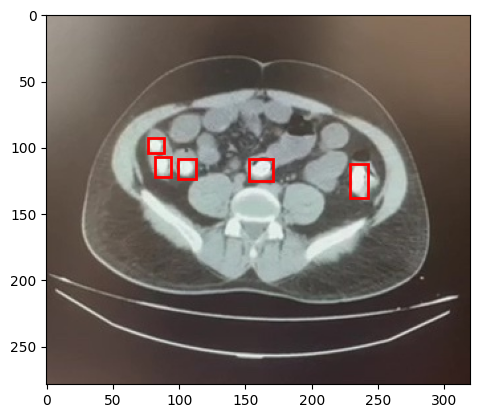

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

np_arr = img_tensor.permute(1, 2, 0).cpu().numpy()
plt.imshow(np_arr)

ax = plt.gca()
for box, label, score in zip(boxes, labels, scores):
  if score > 0.6:
    rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill=False,
                     edgecolor=(1, 0, 0),
                     linewidth=2)
    ax.add_patch(rect)

plt.show()

## Body packer  detection in per%

In [ ]:
model=net
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [ ]:
from torchvision.models import detection
import numpy as np
import argparse
import pickle
import torch
import cv2

In [ ]:
# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
CLASSES = ['body_packer']
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [ ]:
# load the model and set it to evaluation mode
# model = MODELS[args["model"]](pretrained=True, progress=True,
# 	num_classes=len(CLASSES), pretrained_backbone=True).to(DEVICE)
# model.eval()
# model=net
# model.eval()

In [ ]:
# load the image from disk
image = cv2.imread("/content/drive/MyDrive/coco_body_test/images/70e21add-246.jpg")
orig = image.copy()
# convert the image from BGR to RGB channel ordering and change the
# image from channels last to channels first ordering
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))
# add the batch dimension, scale the raw pixel intensities to the
# range [0, 1], and convert the image to a floating point tensor
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)
# send the input to the device and pass the it through the network to
# get the detections and predictions
image = image.to(DEVICE)
detections = model(image)[0]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [ ]:
# detections

In [ ]:
# len(detections["boxes"])


In [ ]:
# confidence = detections["scores"][2]
# confidence

[INFO] body_packer: 97.60%
codde:Mohtarami Under the supervision of: Professor Dr.Babak Mostafazadeh


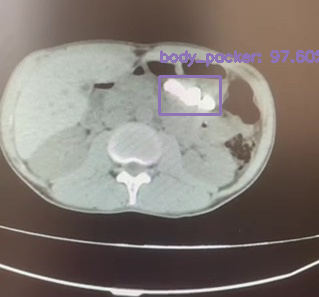

-1

In [ ]:
from google.colab.patches import cv2_imshow
for i in range(0, len(detections["boxes"])):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections["scores"][i]
	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.8:
		# extract the index of the class label from the detections,
		# then compute the (x, y)-coordinates of the bounding box
		# for the object
		idx = int(detections["labels"][i])
		box = detections["boxes"][i].detach().cpu().numpy()
		(startX, startY, endX, endY) = box.astype("int")
		# display the prediction to our terminal
		label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
		print("[INFO] {}".format(label))
		# draw the bounding box and label on the image
		cv2.rectangle(orig, (startX, startY), (endX, endY),
			COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		cv2.putText(orig, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
# show the output image
print("codde:Mohtarami Under the supervision of: Professor Dr.Babak Mostafazadeh")
cv2_imshow( orig)

# display(orig)
cv2.waitKey(0)

## Video from Detection Body packer

In [ ]:
# import the necessary packages
from torchvision.models import detection
from imutils.video import VideoStream
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import pickle
import torch
import time
import cv2

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the list of categories in the COCO dataset and then generate a
# set of bounding box colors for each class

CLASSES = ['body_packer']
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [ ]:
# net=model.load_state_dict(torch.load("/content/drive/MyDrive/coco_body_train/save_w.pt"))

In [ ]:
model=net


In [ ]:
from imutils.video import FileVideoStream

In [ ]:
# initialize the video stream, allow the camera sensor to warmup,
# and initialize the FPS counter
print("[INFO] starting video stream...")
# vs = VideoStream(src='0').start()
vs = cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/6.MP4")
#  vs= FileVideoStream("/content/drive/MyDrive/Colab Notebooks/6.MP4")
# vs = cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/6.MP4")
# time.sleep(2.0)
fps = FPS().start()


[INFO] starting video stream...


In [ ]:
# type(vs)

In [ ]:
# frame = vs.read()
# type(frame)

In [ ]:
# frame

In [ ]:
from IPython.display import clear_output

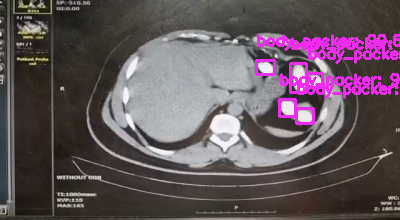

In [ ]:

while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	(grabbed, frame) = vs.read()
	type(frame)
	# frame.shape
  # (grabbed, frame) = vs.read()
	frame = imutils.resize(frame, width=400)

	orig = frame.copy()
	# convert the frame from BGR to RGB channel ordering and change
	# the frame from channels last to channels first ordering
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	frame = frame.transpose((2, 0, 1))
	# add a batch dimension, scale the raw pixel intensities to the
	# range [0, 1], and convert the frame to a floating point tensor
	frame = np.expand_dims(frame, axis=0)
	frame = frame / 255.0
	frame = torch.FloatTensor(frame)
	# send the input to the device and pass the it through the
	# network to get the detections and predictions
	frame = frame.to(DEVICE)
	detections = model(frame)[0]
	for i in range(0, len(detections["boxes"])):
		# extract the confidence (i.e., probability) associated with
		# the prediction
		confidence = detections["scores"][i]
		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.8:
			# extract the index of the class label from the
			# detections, then compute the (x, y)-coordinates of
			# the bounding box for the object
			idx = int(detections["labels"][i])
			box = detections["boxes"][i].detach().cpu().numpy()
			(startX, startY, endX, endY) = box.astype("int")
			# draw the bounding box and label on the frame
			label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
			cv2.rectangle(orig, (startX, startY), (endX, endY),
				COLORS[idx], 2)
			y = startY - 15 if startY - 15 > 15 else startY + 15
			cv2.putText(orig, label, (startX, y),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
	clear_output()
	cv2_imshow( orig)

	key = cv2.waitKey(1) & 0xFF
	# if the 'q' key was pressed, break from the loop
	if key == ord("q"):
		break
	# update the FPS counter
	time.sleep(0.1)
	fps.update()
# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()
